# Homework 5
### Stanisław Antonowicz

As with the previous homeworks, I'm using the mushroom dataset.

In [75]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np
import dalex as dx
import sklearn
from IPython.display import Image

### Loading data

Quick look at the data to remind us how it looks:

In [31]:
data = np.genfromtxt('dataset_24_mushroom.csv', delimiter=',', dtype='<U20', skip_header=1)
labels = data[:,-1]
label_encoder = LabelEncoder()
label_encoder.fit(labels)
labels = label_encoder.transform(labels)
class_names = label_encoder.classes_
data = data[:,:-1]

categorical_features = list(range(22))


categorical_names = """1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s 
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s  
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y  
4. bruises?: bruises=t,no=f  
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s  
6. gill-attachment: attached=a,descending=d,free=f,notched=n  
7. gill-spacing: close=c,crowded=w,distant=d  
8. gill-size: broad=b,narrow=n  
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y  
10. stalk-shape: enlarging=e,tapering=t  
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?  
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s  
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s  
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y  
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y  
16. veil-type: partial=p,universal=u  
17. veil-color: brown=n,orange=o,white=w,yellow=y  
18. ring-number: none=n,one=o,two=t  
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z  
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y  
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y  
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d""".split('\n')

feature_names = []
for ind, line in enumerate(categorical_names):
    vals = line.strip().split('. ')[1]
    feature_name, values = vals.split(': ')
    feature_names.append(feature_name.strip())
    values = {x.split('=')[1]: x.split('=')[0] for x in values.split(',')}
    data[:,ind] = np.array([values[x.strip("'")] for x in data[:,ind]])

data = pd.DataFrame(data)
data.columns = feature_names

In [32]:
data

,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,enlarging,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,convex,scaly,white,bruises,pungent,free,close,narrow,brown,enlarging,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,knobbed,smooth,brown,no,none,attached,close,broad,yellow,enlarging,...,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8120,convex,smooth,brown,no,none,attached,close,broad,yellow,enlarging,...,smooth,orange,orange,partial,brown,one,pendant,buff,several,leaves
8121,flat,smooth,brown,no,none,attached,close,broad,brown,enlarging,...,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8122,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,tapering,...,silky,white,white,partial,white,one,evanescent,white,several,leaves


In [33]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [34]:
categorical_features = data.columns
categorical_transformer = Pipeline(
    steps=[
        ('one_hot_encoder', OneHotEncoder())
    ]
)


transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_features)
    ]
)

In [56]:
model_rf = Pipeline(
    steps=[
        ('transformer', transformer),
        ('model', RandomForestClassifier(random_state=43422))
    ])

In [57]:
_ = model_rf.fit(X_train, y_train, )

My first model is a random forest with default parameters.

I'll skip showing classification reports this time – as always, the prediction is perfect.

In [83]:
rfc_explainer = dx.Explainer(model_rf, X_train, y_train, label='Basic RF')
pvi_rfc = rfc_explainer.model_parts()


Preparation of a new explainer is initiated

  -> data              : 6499 rows 22 cols
  -> target variable   : 6499 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Basic RF
  -> predict function  : <function yhat_proba_default at 0x7fdbb3cb10d0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.482, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.01, mean = 3.85e-05, max = 0.03
  -> model_info        : package sklearn

A new explainer has been created!


Let's look at the variable importance of the model.

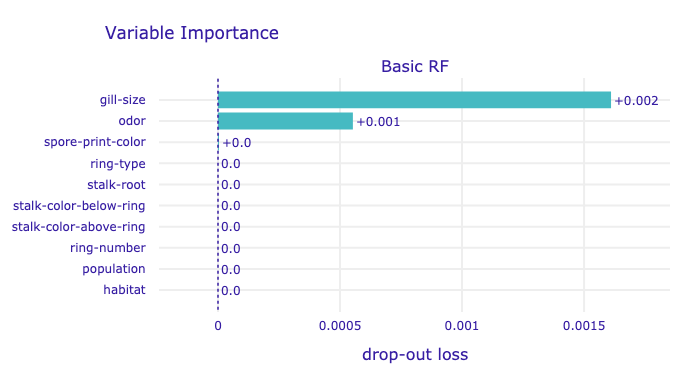

In [84]:
plot = pvi_rfc.plot(show=False)
Image(plot.to_image(format='png'))

It looks like gill size is the most important variable for the model – permuting this feature causes the biggest drop in performance.

I'll train three other models:
- Random Forest without first two most important features (`gill-size` and `odor`)
- Logistic Regression
- Basic neural net

In [18]:
X_train_reduced = X_train.drop(['odor', 'gill-size'], axis=1)
X_test_reduced = X_test.drop(['odor', 'gill-size'], axis=1)

categorical_features_reduced = X_train_reduced.columns
categorical_transformer_reduced = Pipeline(
    steps=[
        ('one_hot_encoder', OneHotEncoder())
    ]
)


transformer_reduced = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer_reduced, categorical_features_reduced)
    ]
)

In [59]:
reduced_rf = Pipeline(
    steps=[
        ('transformer', transformer_reduced),
        ('model', RandomForestClassifier(random_state=43422))
    ])
_ = reduced_rf.fit(X_train_reduced, y_train, )

In [60]:
logistic_regr = Pipeline(
    steps=[
        ('transformer', transformer),
        ('model', LogisticRegression(random_state=43422))
    ])
_ = logistic_regr.fit(X_train, y_train)

In [61]:
neural_net = Pipeline(
    steps=[
        ('transformer', transformer),
        ('model', MLPClassifier(random_state=43422))
    ])
_ = neural_net.fit(X_train, y_train)

In [62]:
reduced_rf_explainer = dx.Explainer(reduced_rf, X_train_reduced, y_train, label='RF no odor and gill size')
logistic_regr_explainer = dx.Explainer(logistic_regr, X_train, y_train, label='Logistic Regression')
neural_net_explainer = dx.Explainer(neural_net, X_train, y_train, label='Neural net')

Preparation of a new explainer is initiated

  -> data              : 6499 rows 20 cols
  -> target variable   : 6499 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : RF no odor and gill size
  -> predict function  : <function yhat_proba_default at 0x7fdbb3cb10d0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.482, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.03, mean = 6.15e-06, max = 0.04
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 6499 rows 22 cols
  -> target variable   : 6499 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label         

In [63]:
pvi_reduced_rf = reduced_rf_explainer.model_parts()
pvi_logistic_regr = logistic_regr_explainer.model_parts()
pvi_neural_net = neural_net_explainer.model_parts()

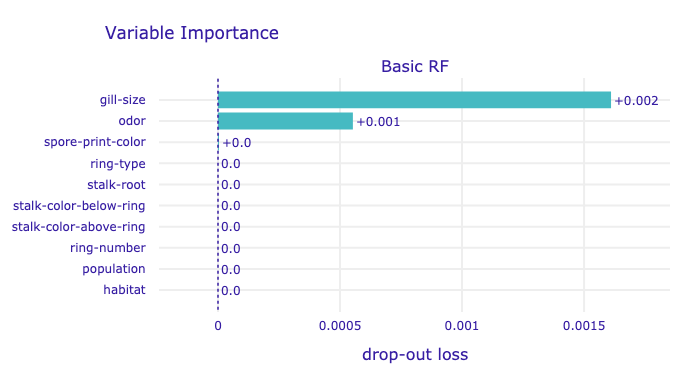

In [85]:
rfc_plot = pvi_rfc.plot(show=False)
Image(rfc_plot.to_image(format='png'))



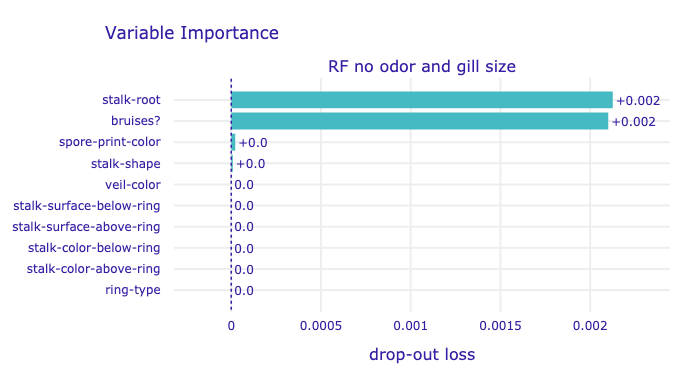

In [80]:
reduced_plot = pvi_reduced_rf.plot(show=False)
Image(reduced_plot.to_image(format='png'))



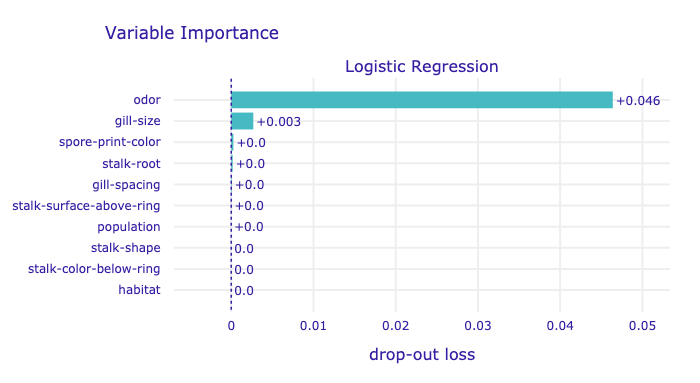

In [81]:
logistic_plot = pvi_logistic_regr.plot(show=False)
Image(logistic_plot.to_image(format='png'))



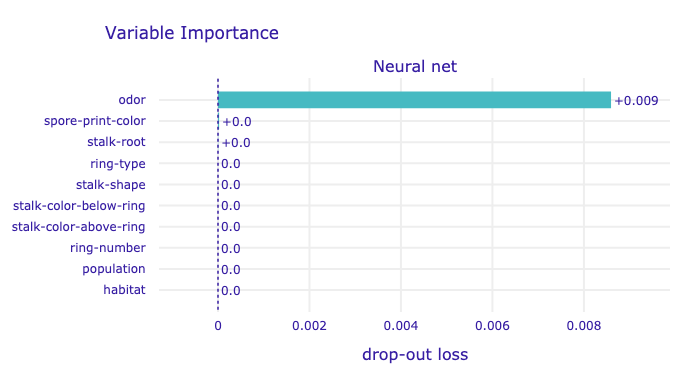

In [82]:
nn_plot = pvi_neural_net.plot(show=False)
Image(nn_plot.to_image(format='png'))

### Comments
- Logistic Regression and Neural Net, despite being similar models, have a bit different varialble importance profiles:
    - Neural Net doesn't consider `gill-size` as an important variable.
    - Logistic Regression does.
    - They both consider `odor` as the most important one though.
- After removing `odor` and `gill-size` from the variables, two most important variables turned out to be different than the two most important ones for the Basic RF besides `odor` and `gill-size`.
- Basic RF, Logistic Regression and Neural net have very similar most important variables (except Neural Net doesn't consider `gill-size` as important).
- Given that all of the models regarded `odor` and almost all of them `gill-size` as important variables, let's see what are the proportions of labels for each of variables' factors.

In [71]:
from collections import defaultdict, Counter
odor_types_to_label = defaultdict(Counter)
gill_size_to_label = defaultdict(Counter)
for record, label in zip(data.to_dict(orient='records'), labels):
    odor_types_to_label[record['odor']]['poisonous' if label else 'edible'] += 1
    gill_size_to_label[record['gill-size']]['poisonous' if label else 'edible'] += 1

In [72]:
print('Odor type to label counts')
for key, counter in odor_types_to_label.items():
    print(key)
    for label, count in counter.items():
        print(f'\t {label}: {count}')

Odor type to label counts
pungent
	 poisonous: 256
almond
	 edible: 400
anise
	 edible: 400
none
	 edible: 3408
	 poisonous: 120
foul
	 poisonous: 2160
creosote
	 poisonous: 192
fishy
	 poisonous: 576
spicy
	 poisonous: 576
musty
	 poisonous: 36


In [73]:
print('Gill size to label counts')
for key, counter in gill_size_to_label.items():
    print(key)
    for label, count in counter.items():
        print(f'\t {label}: {count}')

Gill size to label counts
narrow
	 poisonous: 2224
	 edible: 288
broad
	 edible: 3920
	 poisonous: 1692


It looks like `odor` predicts the true class almost perfectly. It's not a surprise it's importance is high for Logistic Regression and Neural Net. The smaller importance with the Basic RF might be caused by the way RF avoids overfitting with randomly choosing a subset of variables that are used when constructing decision trees.

As for `gill-size`, the situation isn't that clear, although `gill-size` being narrow almost perfectly predicts a mushroom being poisonous.

# Appendix

# Homework 5
### Stanisław Antonowicz

As with the previous homeworks, I'm using the mushroom dataset.

In [75]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np
import dalex as dx
import sklearn
from IPython.display import Image

### Loading data

Quick look at the data to remind us how it looks:

In [31]:
data = np.genfromtxt('dataset_24_mushroom.csv', delimiter=',', dtype='<U20', skip_header=1)
labels = data[:,-1]
label_encoder = LabelEncoder()
label_encoder.fit(labels)
labels = label_encoder.transform(labels)
class_names = label_encoder.classes_
data = data[:,:-1]

categorical_features = list(range(22))


categorical_names = """1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s 
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s  
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y  
4. bruises?: bruises=t,no=f  
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s  
6. gill-attachment: attached=a,descending=d,free=f,notched=n  
7. gill-spacing: close=c,crowded=w,distant=d  
8. gill-size: broad=b,narrow=n  
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y  
10. stalk-shape: enlarging=e,tapering=t  
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?  
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s  
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s  
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y  
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y  
16. veil-type: partial=p,universal=u  
17. veil-color: brown=n,orange=o,white=w,yellow=y  
18. ring-number: none=n,one=o,two=t  
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z  
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y  
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y  
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d""".split('\n')

feature_names = []
for ind, line in enumerate(categorical_names):
    vals = line.strip().split('. ')[1]
    feature_name, values = vals.split(': ')
    feature_names.append(feature_name.strip())
    values = {x.split('=')[1]: x.split('=')[0] for x in values.split(',')}
    data[:,ind] = np.array([values[x.strip("'")] for x in data[:,ind]])

data = pd.DataFrame(data)
data.columns = feature_names

In [32]:
data

,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,enlarging,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,convex,scaly,white,bruises,pungent,free,close,narrow,brown,enlarging,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,knobbed,smooth,brown,no,none,attached,close,broad,yellow,enlarging,...,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8120,convex,smooth,brown,no,none,attached,close,broad,yellow,enlarging,...,smooth,orange,orange,partial,brown,one,pendant,buff,several,leaves
8121,flat,smooth,brown,no,none,attached,close,broad,brown,enlarging,...,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8122,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,tapering,...,silky,white,white,partial,white,one,evanescent,white,several,leaves


In [33]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [34]:
categorical_features = data.columns
categorical_transformer = Pipeline(
    steps=[
        ('one_hot_encoder', OneHotEncoder())
    ]
)


transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_features)
    ]
)

In [56]:
model_rf = Pipeline(
    steps=[
        ('transformer', transformer),
        ('model', RandomForestClassifier(random_state=43422))
    ])

In [57]:
_ = model_rf.fit(X_train, y_train, )

My first model is a random forest with default parameters.

I'll skip showing classification reports this time – as always, the prediction is perfect.

In [83]:
rfc_explainer = dx.Explainer(model_rf, X_train, y_train, label='Basic RF')
pvi_rfc = rfc_explainer.model_parts()


Preparation of a new explainer is initiated

  -> data              : 6499 rows 22 cols
  -> target variable   : 6499 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Basic RF
  -> predict function  : <function yhat_proba_default at 0x7fdbb3cb10d0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.482, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.01, mean = 3.85e-05, max = 0.03
  -> model_info        : package sklearn

A new explainer has been created!


Let's look at the variable importance of the model.

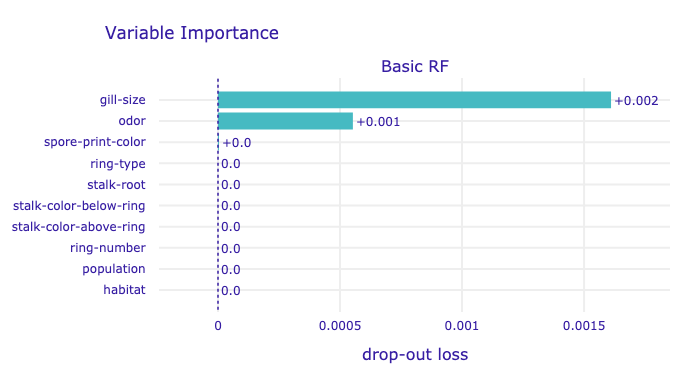

In [84]:
plot = pvi_rfc.plot(show=False)
Image(plot.to_image(format='png'))

It looks like gill size is the most important variable for the model – permuting this feature causes the biggest drop in performance.

I'll train three other models:
- Random Forest without first two most important features (`gill-size` and `odor`)
- Logistic Regression
- Basic neural net

In [18]:
X_train_reduced = X_train.drop(['odor', 'gill-size'], axis=1)
X_test_reduced = X_test.drop(['odor', 'gill-size'], axis=1)

categorical_features_reduced = X_train_reduced.columns
categorical_transformer_reduced = Pipeline(
    steps=[
        ('one_hot_encoder', OneHotEncoder())
    ]
)


transformer_reduced = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer_reduced, categorical_features_reduced)
    ]
)

In [59]:
reduced_rf = Pipeline(
    steps=[
        ('transformer', transformer_reduced),
        ('model', RandomForestClassifier(random_state=43422))
    ])
_ = reduced_rf.fit(X_train_reduced, y_train, )

In [60]:
logistic_regr = Pipeline(
    steps=[
        ('transformer', transformer),
        ('model', LogisticRegression(random_state=43422))
    ])
_ = logistic_regr.fit(X_train, y_train)

In [61]:
neural_net = Pipeline(
    steps=[
        ('transformer', transformer),
        ('model', MLPClassifier(random_state=43422))
    ])
_ = neural_net.fit(X_train, y_train)

In [62]:
reduced_rf_explainer = dx.Explainer(reduced_rf, X_train_reduced, y_train, label='RF no odor and gill size')
logistic_regr_explainer = dx.Explainer(logistic_regr, X_train, y_train, label='Logistic Regression')
neural_net_explainer = dx.Explainer(neural_net, X_train, y_train, label='Neural net')

Preparation of a new explainer is initiated

  -> data              : 6499 rows 20 cols
  -> target variable   : 6499 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : RF no odor and gill size
  -> predict function  : <function yhat_proba_default at 0x7fdbb3cb10d0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.482, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.03, mean = 6.15e-06, max = 0.04
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 6499 rows 22 cols
  -> target variable   : 6499 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label         

In [63]:
pvi_reduced_rf = reduced_rf_explainer.model_parts()
pvi_logistic_regr = logistic_regr_explainer.model_parts()
pvi_neural_net = neural_net_explainer.model_parts()

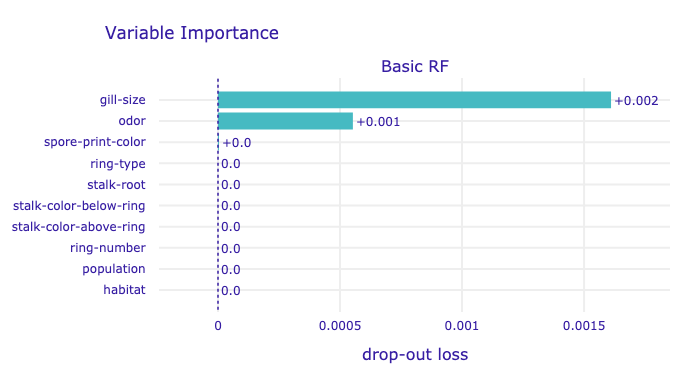

In [85]:
rfc_plot = pvi_rfc.plot(show=False)
Image(rfc_plot.to_image(format='png'))



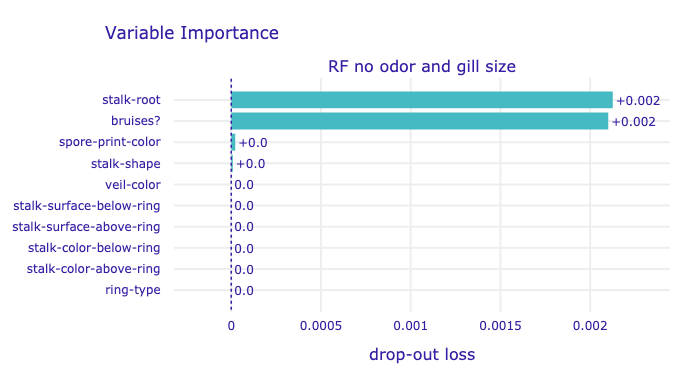

In [80]:
reduced_plot = pvi_reduced_rf.plot(show=False)
Image(reduced_plot.to_image(format='png'))



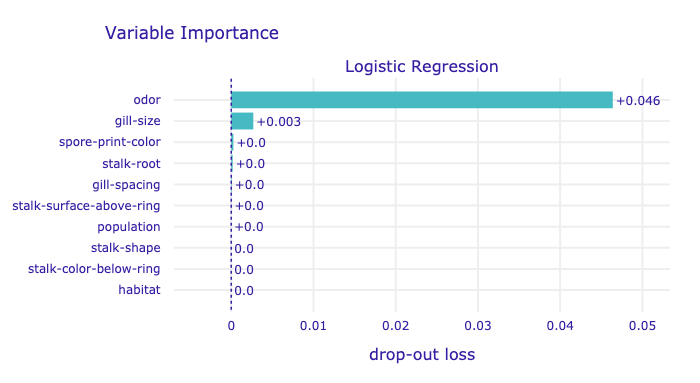

In [81]:
logistic_plot = pvi_logistic_regr.plot(show=False)
Image(logistic_plot.to_image(format='png'))



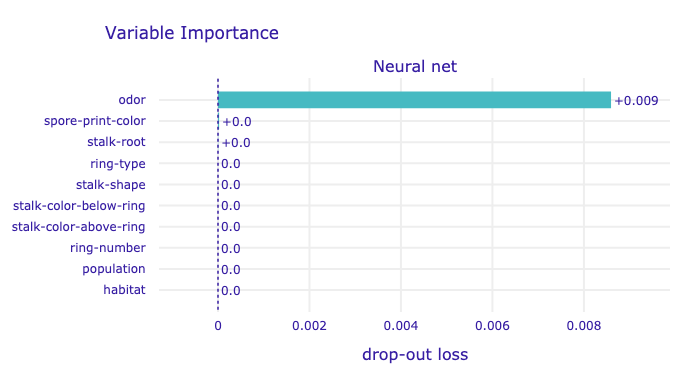

In [82]:
nn_plot = pvi_neural_net.plot(show=False)
Image(nn_plot.to_image(format='png'))

### Comments
- Logistic Regression and Neural Net, despite being similar models, have a bit different varialble importance profiles:
    - Neural Net doesn't consider `gill-size` as an important variable.
    - Logistic Regression does.
    - They both consider `odor` as the most important one though.
- After removing `odor` and `gill-size` from the variables, two most important variables turned out to be different than the two most important ones for the Basic RF besides `odor` and `gill-size`.
- Basic RF, Logistic Regression and Neural net have very similar most important variables (except Neural Net doesn't consider `gill-size` as important).
- Given that all of the models regarded `odor` and almost all of them `gill-size` as important variables, let's see what are the proportions of labels for each of variables' factors.

In [71]:
from collections import defaultdict, Counter
odor_types_to_label = defaultdict(Counter)
gill_size_to_label = defaultdict(Counter)
for record, label in zip(data.to_dict(orient='records'), labels):
    odor_types_to_label[record['odor']]['poisonous' if label else 'edible'] += 1
    gill_size_to_label[record['gill-size']]['poisonous' if label else 'edible'] += 1

In [72]:
print('Odor type to label counts')
for key, counter in odor_types_to_label.items():
    print(key)
    for label, count in counter.items():
        print(f'\t {label}: {count}')

Odor type to label counts
pungent
	 poisonous: 256
almond
	 edible: 400
anise
	 edible: 400
none
	 edible: 3408
	 poisonous: 120
foul
	 poisonous: 2160
creosote
	 poisonous: 192
fishy
	 poisonous: 576
spicy
	 poisonous: 576
musty
	 poisonous: 36


In [73]:
print('Gill size to label counts')
for key, counter in gill_size_to_label.items():
    print(key)
    for label, count in counter.items():
        print(f'\t {label}: {count}')

Gill size to label counts
narrow
	 poisonous: 2224
	 edible: 288
broad
	 edible: 3920
	 poisonous: 1692


It looks like `odor` predicts the true class almost perfectly. It's not a surprise it's importance is high for Logistic Regression and Neural Net. The smaller importance with the Basic RF might be caused by the way RF avoids overfitting with randomly choosing a subset of variables that are used when constructing decision trees.

As for `gill-size`, the situation isn't that clear, although `gill-size` being narrow almost perfectly predicts a mushroom being poisonous.